SIDE NOTE: would love to get any critiques, hints, tips, oberservations on any level not just on ML (but obviously ML as the priority).  Beginner Python learner (though I took the Full Stack Course) so any suggestions there are welcome.  Thanks.

Will need to import these libs plus setting some global variables

In [1]:
import sys
import os
import numpy as np
import renders as rs
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import display # Allows the use of display() for DataFrames
from sklearn.externals import joblib
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.cross_validation import StratifiedKFold
from sklearn.svm import SVC
import matplotlib.cm as cm
# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Might need to change the path of the included libraries.
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats/match_stats.py')
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats/form_model.py')
sys.path.append('/anaconda/envs/stats/lib/python3.5/site-packages')
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats/model_libs.py')
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats/form_data.py')
sys.path.append('/Users/senzari/Machine_Learning/stats')
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats')
# print(sys.path)
os.chdir('/Users/senzari/Machine_Learning/stats/src')
#print(os.getcwd())

from stats import form_data, match_stats, model_libs, form_model, predict_matches

# Variables
round_number = 27 # for MLS only
target_col = 'points'
ignore_cols = ['match_id', 'team_id', 'team_name', 'opp_id', 'opp_name', 'scheduled', 'games_played', 'round']
sub_cols = ['current_formation', 'avg_goals_against', 'goal_diff', 'win_percentage', 'sos',
           'opp_win_percentage', 'opp_sos', 'current_team_yellow_cards', 'current_team_corner_kicks', 'current_team_first_half_goals', 'current_team_sec_half_goals', 
           'opp_team_yellow_cards', 'opp_team_corner_kicks', 'opp_team_first_half_goals', 'opp_team_sec_half_goals']

all_models = ['log', 'svc', 'gmm', 'knn', 'gnb', 'randomForest']

""" this variable 'testing' should be false if using CSV's and not pulling from the database. """
testing = False

INITIALIZED...


In [2]:
data_csv = 'raw_data_squared.csv'

if testing:
    raw_data = form_data.run_data()
    raw_data.to_csv(data_csv)
    print("Raw Data Saved to CSV")
else:
    #Reading in a CSV adds the first index column
    raw_data = pd.read_csv(data_csv)
    raw_data = raw_data.drop(raw_data.columns[[0]], axis=1)

pd.set_option("display.max_columns", 85)
print('Data Loaded...')
print("Dataset size :: {}".format(raw_data.shape))
display(raw_data.head())

Data Loaded...
Dataset size :: (634, 21)


,match_id,team_id,team_name,opp_id,opp_name,scheduled,round,games_played,is_home,current_formation,goals_for,goals_allowed,opp_goals_allowed,goal_efficiency,opp_defensive_goal_efficiency,ratio_of_attacks,opp_ratio_of_attacks,ratio_ball_safe_to_dangerous_attacks,opp_ratio_ball_safe_to_dangerous_attacks,goals,points
0,249,21,FC Dallas,33,DC United,2016-03-26 21:30:00,4,3,0,4-2-3-1,4,5,5,0.114286,0.750000,0.587097,0.524917,1.210938,1.037931,3,3
1,255,21,FC Dallas,39,Columbus Crew,2016-04-03 01:00:00,5,3,1,4-2-3-1,5,5,4,0.156250,0.818182,0.502976,0.538136,1.183099,0.874074,1,1
2,265,21,FC Dallas,32,San Jose Earthquakes,2016-04-10 01:00:00,6,3,1,4-4-2,6,1,5,0.133333,0.821429,0.495575,0.504323,1.185315,1.074303,2,1
3,272,21,FC Dallas,30,Portland Timbers,2016-04-14 02:30:00,7,3,0,4-4-2,6,3,7,0.146341,0.695652,0.467742,0.609907,1.148148,1.247104,3,3
4,282,21,FC Dallas,27,Sporting Kansas City,2016-04-17 23:00:00,7,3,1,4-4-2,6,3,2,0.146341,0.942857,0.467742,0.534946,1.148148,1.053824,2,3


## FORMATTING

Converting Goals to our binary classification (0-1) and (2+) and also converting the sos and rpi and implementing the team to a particular rpi quartile

In [3]:
# Helper Function - Removes Columns to Ignore and Splits the Target Column
def split_target(data):
    td = model_libs._clone_and_drop(data, ignore_cols)
    (y, X) = model_libs._extract_target(td, target_col)
    return X, y

""" Need to do some formatting of the Data before we run the models"""
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)

rankings_data = raw_data.copy()
rankings_data["offensive_ranking"] = pd.Series(None, index=rankings_data.index)
rankings_data["opp_defensive_ranking"] = pd.Series(None, index=rankings_data.index)

leagues = model_libs.get_leagues_country_codes()
#leagues = { "epl": 'ENG' }
teams = form_data.get_teams()
league_rounds = model_libs.get_leagues_rounds()
test = False
if test:
    """ Going through each League"""
    for key, value in leagues.iteritems():
        print(key)
        country_code = leagues[key]
        round_num = league_rounds[key]
        #round_num = 6
        teams_in_league = teams[teams["country_code"] == country_code]
        """ Looping through the Rounds """
        for i in range(4, round_num):
            print("ROUND :: {} ".format(i))
            offensive_rankings = form_data.get_rankings(teams_in_league, i, "offensive")
            rankings = model_libs.quartile_list(offensive_rankings, True)
            offensive_rankings["offensive_rankings_quartiled"] = rankings
            print("Finished with Offensive Rankings")
            #print(offensive_rankings)

            defensive_rankings = form_data.get_rankings(teams_in_league, i, "defensive")
            rankings = model_libs.quartile_list(defensive_rankings, False)
            defensive_rankings["defensive_rankings_quartiled"] = rankings
            print("Finished with Defensive Rankings")
            #print(defensive_rankings)

            """ Loop through each Team in the League for that round and assign an Offensive Rank """
            for key, team in teams_in_league.iterrows():
                
                ''' If the team is the team_id then put in their offensive ranking for that game '''
                offensive_rank = offensive_rankings.loc[offensive_rankings[0] == team['id'], "offensive_rankings_quartiled"]
                idx = rankings_data.loc[(rankings_data["team_id"] == team["id"]) 
                        & (rankings_data["round"] == (i)), "offensive_ranking"].index

                rankings_data.set_value(idx, "offensive_ranking", offensive_rank.values[0])
                ''' If the team is the opp then put in their defensive ranking for that game '''
                defensive_rank = defensive_rankings.loc[defensive_rankings[0] == team['id'], "defensive_rankings_quartiled"]
                opp_idx = rankings_data.loc[(rankings_data["opp_id"] == team["id"]) 
                        & (rankings_data["round"] == (i))].index

                rankings_data.set_value(opp_idx, "opp_defensive_ranking", defensive_rank.values[0])
                
                rankings_data.to_csv('rankings_data.csv')
                
else:
    
    rankings_data = pd.read_csv('rankings_data.csv')
    rankings_data = rankings_data.drop(rankings_data.columns[[0]], axis=1)
    
print('Data Loaded...')
                          
""" Formatting data to convert goals scored to the correct category"""
# Not using points as a target for this version, using goals
rankings_data = rankings_data.drop('goals', 1)

#rankings_data['converted_goals'] = rankings_data.apply(lambda row: model_libs.set_group(row['goals']), axis=1)

rankings_data = rankings_data.drop(ignore_cols + ['current_formation'], 1)
display(rankings_data.head())

Data Loaded...


,is_home,goals_for,goals_allowed,opp_goals_allowed,goal_efficiency,opp_defensive_goal_efficiency,ratio_of_attacks,opp_ratio_of_attacks,ratio_ball_safe_to_dangerous_attacks,opp_ratio_ball_safe_to_dangerous_attacks,points,offensive_ranking,opp_defensive_ranking
0,0,4,5,5,0.114286,0.750000,0.587097,0.524917,1.210938,1.037931,3,1,0.66666
1,1,5,5,4,0.156250,0.818182,0.502976,0.538136,1.183099,0.874074,1,1,0.33333
2,1,6,1,5,0.133333,0.821429,0.495575,0.504323,1.185315,1.074303,1,1,0.00000
3,0,6,3,7,0.146341,0.695652,0.467742,0.609907,1.148148,1.247104,3,1,0.33333
4,1,6,3,2,0.146341,0.942857,0.467742,0.534946,1.148148,1.053824,3,1,0.33333


### RUNNING CLASSIFICATION MODEL ON IF TEAMS SCORE 0-1 OR 1-2 ON GAMES

In [4]:
def run_features(data, drop_data, target, models):
    
    new_data = data.drop(drop_data, axis=1)
    
    #display(new_data.head())
    
    (y, X) = model_libs._extract_target(new_data, target)
    
    models = form_model.train_models(round_number, X, y, models)
    
    return models

#rankings_data = rankings_data.drop(['goals_for', 'goals_allowed', 'opp_goals_allowed'], 1)
#### Running ALL Features 
models_test_1 = run_features(rankings_data, [], 'points', ["knn"])

(rankings_y, rankings_X) = model_libs._extract_target(rankings_data, 'points')

def check_accuracy(model, data_X):
    actual_y = pd.DataFrame(rankings_y.values, columns=['actual'])
    predictions = pd.DataFrame(model.predict(data_X), columns=['predictions'])
    preds = pd.concat([predictions, actual_y], axis=1)
    preds['diff'] = preds.apply(lambda r: model_libs.predictions_diff(r['predictions'], r['actual']), axis=1)
    accuracy = np.divide(preds['diff'].sum(), float(len(preds['diff'])))
    print(accuracy)

for m in models_test_1:
    check_accuracy(m, rankings_X)

-----------------------------------
Training K Neighbors Classifier Model
KNN Score on Training Set :: 0.668639053254
KNN Score on Test Set:: 0.393700787402
Finished K-Means Modeling
0.61356466877


In [ ]:
def train_tuned_models(round_num, X, y):
    for i in all_models:
        models = form_model.build_tuned_model(X, y, i)
        
    return models
        
tuned_models = train_tuned_models(round_number, classifier_X, classifier_y)

In [5]:
log_model = form_model.build_tuned_model(rankings_X, rankings_y, 'log')

for m in log_model:
    print(m)
    check_accuracy(m, rankings_X)

Training LOG REG Model
Score on Training Set :: 0.473372781065
Score on Test Set :: 0.472440944882
Finished LOG REG Modeling
LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.473186119874


In [6]:
random_forest_model = form_model.build_tuned_model(rankings_X, rankings_y, 'randomForest')

for m in random_forest_model:
    print(m)
    check_accuracy(m, rankings_X)

-----------------------------------
Training Random Forest Model
[ 0.33980583  0.37254902  0.38613861  0.36633663  0.43      ]
Accuracy: 0.38 (+/- 0.06)
Finished Random Forest Modeling
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features=2,
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=11, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.604100946372


In [7]:
knn_model = form_model.build_tuned_model(rankings_X, rankings_y, 'knn')

for m in knn_model:
    check_accuracy(m, rankings_X)

-----------------------------------
Training K-Means Model
KNN Score :: 0.673267326733 for Training
KNN Score :: 0.395348837209 for Testing
KNN Score :: 0.680473372781 for Training
KNN Score :: 0.346456692913 for Testing
KNN Score :: 0.665354330709 for Training
KNN Score :: 0.333333333333 for Testing
KNN Score :: 0.681102362205 for Training
KNN Score :: 0.404761904762 for Testing
KNN Score :: 0.661417322835 for Training
KNN Score :: 0.349206349206 for Testing
Finished K-Means Modeling
0.599369085174


In [8]:
gnb_model = form_model.build_tuned_model(rankings_X, rankings_y, 'gnb')

for m in gnb_model:
    print(m)
    check_accuracy(m, rankings_X)

-----------------------------------
Training Gaussian NB Model
[ 0.45631068  0.46078431  0.52475248  0.47524752  0.54      ]
Accuracy: 0.49 (+/- 0.07)
Finished Gaussian NB Modeling
GaussianNB()
0.488958990536


In [9]:
svc_model = form_model.build_tuned_model(rankings_X, rankings_y, 'svc')

for m in svc_model:
    print(m)
    check_accuracy(m, rankings_X)

Training and Tuning SVC Model
[ 0.37795276  0.47826087]
Accuracy: 0.43 (+/- 0.10)
Finished SVC Modeling
GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['rbf'], 'C': [1, 10, 100]}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)
0.531545741325


In [10]:
gmm_model = form_model.build_tuned_model(rankings_X, rankings_y, 'gmm')

for m in gmm_model:
    print(m)
    check_accuracy(m, rankings_X)

-----------------------------------
Training and Tuning GMM Model
W/ Covariance Type :: spherical
# of Components :: 2
Silhouette Score :: 0.232279256186 for Training
Silhouette Score :: 0.207359602647 for Testing
# of Components :: 3
Silhouette Score :: 0.239971700233 for Training
Silhouette Score :: 0.208352437605 for Testing
# of Components :: 4
Silhouette Score :: 0.227612078523 for Training
Silhouette Score :: 0.195080735537 for Testing
W/ Covariance Type :: tied
# of Components :: 2
Silhouette Score :: 0.106665812575 for Training
Silhouette Score :: 0.0758985129718 for Testing
# of Components :: 3
Silhouette Score :: 0.0712304304591 for Training
Silhouette Score :: 0.0398268791945 for Testing
# of Components :: 4
Silhouette Score :: 0.0709234267906 for Training
Silhouette Score :: 0.0152943617139 for Testing
W/ Covariance Type :: diag
# of Components :: 2
Silhouette Score :: 0.210506663642 for Training
Silhouette Score :: 0.235323993223 for Testing
# of Components :: 3
Silhouette

Cross Validating the SVC model with the PCA data to help prevent overfitting

In [11]:
prediction_models = form_model.load_models(['knn', 'svc', 'randomForest', 'gnb', 'gmm', 'log'])

Success :: Loaded - knn
Success :: Loaded - svc
Success :: Loaded - randomForest
Success :: Loaded - gnb
Success :: Loaded - gmm
Success :: Loaded - log


In [12]:
print('Upcoming matches')
#upcoming_matches, match_details = predict_matches.get_upcoming_matches()
#upcoming_matches.to_csv('upcoming_matches.csv')
upcoming_matches = pd.read_csv('upcoming_matches.csv')
upcoming_matches = upcoming_matches.drop(upcoming_matches.columns[[0]], axis=1)
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
upcoming_data = predict_matches.predictions(upcoming_matches)


print('Loaded...')
upcoming_data["offensive_ranking"] = pd.Series(None, index=rankings_data.index)
upcoming_data["opp_defensive_ranking"] = pd.Series(None, index=rankings_data.index)

leagues = model_libs.get_leagues_country_codes()
teams = form_data.get_teams()
league_rounds = model_libs.get_leagues_rounds()
test = False
if test:
    """ Going through each League"""
    for key, value in leagues.iteritems():
        print(key)
        country_code = leagues[key]
        round_num = league_rounds[key]
        teams_in_league = teams[teams["country_code"] == country_code]
        
        print("ROUND :: {} ".format(round_num))
        offensive_rankings = form_data.get_rankings(teams_in_league, round_num, "offensive", True)
        print(offensive_rankings)
        rankings = model_libs.quartile_list(offensive_rankings, True)
        offensive_rankings["offensive_rankings_quartiled"] = rankings
        #print(offensive_rankings)
        print("Finished with Offensive Rankings")

        defensive_rankings = form_data.get_rankings(teams_in_league, round_num, "defensive", True)
        rankings = model_libs.quartile_list(defensive_rankings, False)
        defensive_rankings["defensive_rankings_quartiled"] = rankings
        #print(defensive_rankings)
        print("Finished with Defensive Rankings")

        """ Loop through each Team in the League for that round and assign an Offensive Rank """
        for key, team in teams_in_league.iterrows():
                
            ''' If the team is the team_id then put in their offensive ranking for that game '''
            offensive_rank = offensive_rankings.loc[offensive_rankings[0] == team['id'], "offensive_rankings_quartiled"]
            idx = upcoming_data.loc[(upcoming_data["team_id"] == team["id"]) 
                    & (upcoming_data["round"] == (round_num)), "offensive_ranking"].index
            upcoming_data.set_value(idx, "offensive_ranking", offensive_rank.values[0])
            
            ''' If the team is the opp then put in their defensive ranking for that game '''
            defensive_rank = defensive_rankings.loc[defensive_rankings[0] == team['id'], "defensive_rankings_quartiled"]
            opp_idx = upcoming_data.loc[(upcoming_data["opp_id"] == team["id"]) 
                    & (upcoming_data["round"] == (round_num))].index

            upcoming_data.set_value(opp_idx, "opp_defensive_ranking", defensive_rank.values[0])
                
            upcoming_data.to_csv('upcoming_ranking_data.csv')
                
else:
    
    upcoming_data = pd.read_csv('upcoming_ranking_data.csv')
    upcoming_data = upcoming_data.drop(upcoming_data.columns[[0]], axis=1)




display(upcoming_data.head())

Upcoming matches
Loaded...


,match_id,team_id,team_name,opp_id,opp_name,scheduled,round,games_played,is_home,current_formation,goals_for,goals_allowed,opp_goals_allowed,goal_efficiency,opp_defensive_goal_efficiency,ratio_of_attacks,opp_ratio_of_attacks,ratio_ball_safe_to_dangerous_attacks,opp_ratio_ball_safe_to_dangerous_attacks,goals,points,offensive_ranking,opp_defensive_ranking
0,900,21,FC Dallas,23,Real Salt Lake,2016-09-25 01:30:00,28,3,0,4-2-3-1,5,4,5,0.128205,0.782609,0.541528,0.396947,1.264706,0.970370,0,0,1.00000,1.00000
1,896,22,Colorado Rapids,28,Vancouver Whitecaps FC,2016-09-24 23:00:00,28,3,0,4-2-3-1,1,2,3,0.041667,0.896552,0.482993,0.591973,1.050000,1.150000,0,0,0.00000,0.66666
2,900,23,Real Salt Lake,21,FC Dallas,2016-09-25 01:30:00,28,3,1,4-3-3,3,5,4,0.088235,0.800000,0.561934,0.480263,1.153310,0.924012,0,0,0.33333,1.00000
3,894,24,New York City FC,40,Chicago Fire,2016-09-24 00:00:00,28,3,1,4-3-3,6,7,4,0.214286,0.888889,0.480263,0.490506,0.924012,1.029316,0,0,0.33333,0.33333
4,895,25,Philadelphia Union,34,Toronto FC,2016-09-24 21:00:00,28,3,0,4-2-3-1,2,6,5,0.064516,0.791667,0.422713,0.505119,1.096886,1.042705,0,0,0.33333,1.00000


In [13]:
""" Need to format the data the same way we did on the raw data """
formatted_upcoming_data = upcoming_data.drop('goals', 1)

formatted_upcoming_data = formatted_upcoming_data.drop(ignore_cols + ['current_formation', 'points'], 1)
display(formatted_upcoming_data.head())

,is_home,goals_for,goals_allowed,opp_goals_allowed,goal_efficiency,opp_defensive_goal_efficiency,ratio_of_attacks,opp_ratio_of_attacks,ratio_ball_safe_to_dangerous_attacks,opp_ratio_ball_safe_to_dangerous_attacks,offensive_ranking,opp_defensive_ranking
0,0,5,4,5,0.128205,0.782609,0.541528,0.396947,1.264706,0.970370,1.00000,1.00000
1,0,1,2,3,0.041667,0.896552,0.482993,0.591973,1.050000,1.150000,0.00000,0.66666
2,1,3,5,4,0.088235,0.800000,0.561934,0.480263,1.153310,0.924012,0.33333,1.00000
3,1,6,7,4,0.214286,0.888889,0.480263,0.490506,0.924012,1.029316,0.33333,0.33333
4,0,2,6,5,0.064516,0.791667,0.422713,0.505119,1.096886,1.042705,0.33333,1.00000


In [14]:
""" Models we'll use to predict on upcoming matches """
# pca_svc_model, knn_model, random_forest_model

# This is all the X values
formatted_upcoming_data

svc_preds = prediction_models[1].predict(formatted_upcoming_data)
svc_decsions = prediction_models[1].decision_function(formatted_upcoming_data)
display(svc_preds)
print(svc_decsions.shape)
decisions = pd.DataFrame(svc_decsions)
display(decisions)
print(svc_decsions)

rf_preds = prediction_models[2].predict(formatted_upcoming_data)
print(rf_preds)
knn_preds = prediction_models[0].predict(formatted_upcoming_data)
print(knn_preds)

gmm_preds = prediction_models[3].predict(formatted_upcoming_data)
print(gmm_preds)

gnb_preds = prediction_models[4].predict(formatted_upcoming_data)
print(gnb_preds)

log_preds = prediction_models[5].predict(formatted_upcoming_data)
print(log_preds)

#linear_preds = lin_regr.predict(upcoming_ranked)
#print(linear_preds)


//anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:547: ChangedBehaviorWarning: The decision_function_shape default value will change from 'ovo' to 'ovr' in 0.18. This will change the shape of the decision function returned by SVC.
  "SVC.", ChangedBehaviorWarning)


array([ 0.,  0.,  3.,  3.,  0.,  0.,  0.,  3.,  0.,  0.,  3.,  3.,  1.,
        3.,  1.,  0.,  0.,  3.,  3.,  0.,  3.,  0.,  3.,  1.,  3.,  3.,
        0.,  0.,  0.,  0.,  3.,  0.,  3.,  0.,  3.,  3.,  0.,  3.,  0.,
        3.,  3.,  0.,  0.,  0.,  0.,  1.,  3.,  3.,  3.,  3.,  0.,  0.,
        1.,  0.,  3.,  3.,  0.,  3.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  0.,  3.,  0.,  3.,  0.,  1.,  0.,  1.,  0.,  3.,
        3.,  0.,  0.,  3.,  0.,  0.,  0.,  3.,  3.,  0.,  3.,  0.,  3.,
        3.,  3.,  0.,  3.,  1.,  0.,  1.])

(98, 3)


,0,1,2
0,1.021371,1.032490,0.762530
1,0.507675,0.913940,0.796313
2,-0.447158,-0.755496,-0.565098
3,-0.781999,-0.897652,-0.288474
4,0.413030,1.037349,0.859378
5,0.420476,0.721650,0.649708
6,0.911857,0.757216,-0.053092
7,-0.191172,-0.840348,-0.494502
8,0.417999,0.855888,0.446214
9,0.933394,1.015583,0.715307


[[ 1.02137135  1.03248959  0.76252999]
 [ 0.50767537  0.91393958  0.79631295]
 [-0.44715752 -0.7554958  -0.56509797]
 [-0.78199908 -0.89765218 -0.28847437]
 [ 0.41302958  1.03734932  0.85937766]
 [ 0.42047633  0.72164997  0.64970784]
 [ 0.9118574   0.75721622 -0.05309162]
 [-0.19117221 -0.84034804 -0.49450186]
 [ 0.41799863  0.85588792  0.44621413]
 [ 0.93339377  1.01558343  0.71530733]
 [-0.18341046 -0.67363307 -0.18531904]
 [-0.40739388 -1.0338563  -0.93002371]
 [-0.98711382 -0.98166617  0.13250552]
 [-1.01094483 -1.01111289 -0.25312248]
 [-0.06305906  0.21597047  0.70585046]
 [ 0.32314253  0.20441569  0.20450078]
 [ 0.36537377  0.61904564  0.65202465]
 [-0.95062586 -1.23986499 -0.67525909]
 [-0.46515848 -0.76165975 -0.56429707]
 [ 0.73079628  0.53089706  0.46753396]
 [-0.24830283 -0.60417978 -0.45082601]
 [ 0.05008935  0.44532988  0.48647527]
 [-0.18298833 -0.12809547 -0.18862139]
 [-0.29502206  0.00399603  0.15175352]
 [ 0.49475443 -0.41495208 -0.89410901]
 [ 0.61080241 -0.0830397 

In [56]:
results_for_upcoming = pd.read_csv('results_for_upcoming.csv')
results_for_upcoming = results_for_upcoming.drop(results_for_upcoming.columns[[0]], axis=1)

,actual
0,1
1,1
2,1
3,1
4,3
5,0
6,1
7,1
8,0
9,3


(634, 2)
Training LOG REG Model
Score on Training Set :: 0.351084812623
Score on Test Set :: 0.322834645669
Finished LOG REG Modeling
-----------------------------------
Training K Neighbors Classifier Model
KNN Score on Training Set :: 0.682445759369
KNN Score on Test Set:: 0.330708661417
Finished K-Means Modeling
-----------------------------------
Training Gaussian NB Model
F1 score for training set: 0.315103460739
F1 score for test set: 0.257938694302
Finished Gaussian NB Modeling
-----------------------------------
Training SVC Model
F1 score for training set: 0.544292192276
F1 score for test set: 0.302000917326
Finished SVC Modeling
-----------------------------------
Random Forest Classifier Model
Training set: 0.603980528371
Test set: 0.254273504274
Finished Random Forest Classifier Modeling


,points,Dimension 1,Dimension 2
0,3,-0.387251,-1.19067


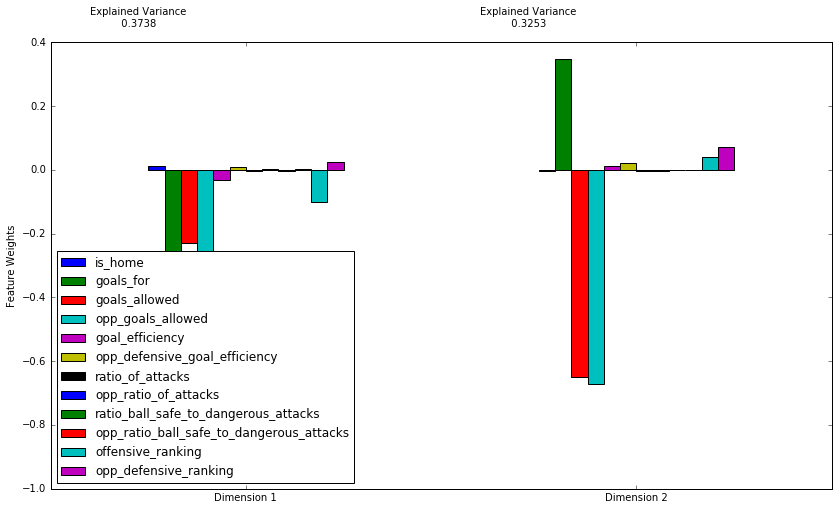

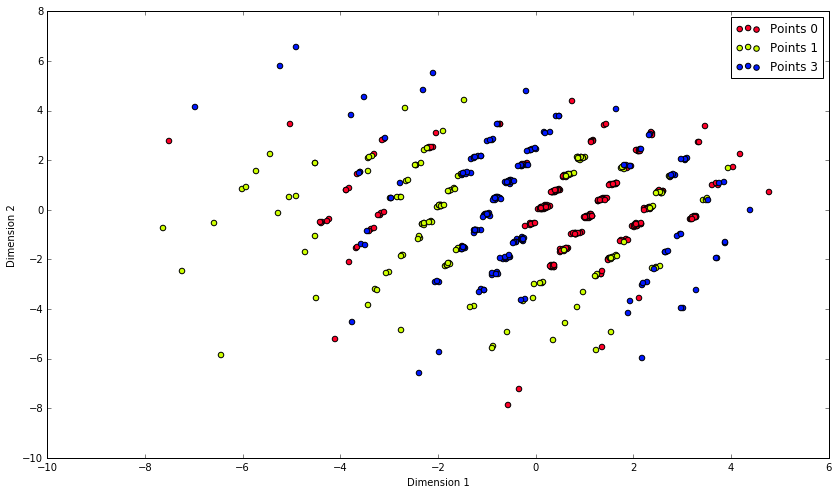

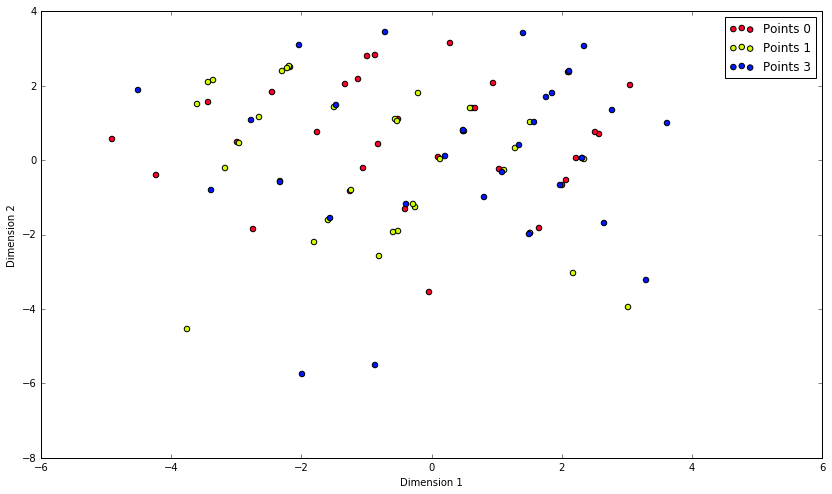

In [59]:
def plot_PCA(data, preds):
    
    pca = PCA(n_components=2)
    pca.fit(data)
    
    # Generate PCA results plot
    pca_results = rs.pca_results(data, pca)
    #print(pca_results)
    pca_data = pca.transform(data)
    
    # Create a DataFrame for the reduced data
    pca_data = pd.DataFrame(pca_data, columns = ['Dimension 1', 'Dimension 2'])
    plot_data = pd.concat([preds, pca_data], axis = 1)
    display(plot_data.head(1))
    # Scatterplotting the transformed data if it's 2 Dimensions
    fig, ax = plt.subplots(figsize = (14,8))
    cmap = cm.get_cmap('gist_rainbow')
    
    for i, cluster in plot_data.groupby('points'):   
        cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', 
                     color = cmap((i)*1.0/(4)), label = 'Points %i'%(i), s=30);
    
    return pca, pca_data, pca_results


(rankings_y, rankings_X) = model_libs._extract_target(rankings_data, 'points')

print(pca_data.shape)

# Runs models on PCA to see if there is a difference in the results
pca_models = run_features(all_pca_data, [], 'points', ['log', 'knn', 'gnb', 'svc', 'randomForest'])

preds = pd.DataFrame(pca_models[4].predict(pca_X), columns=['points'])

""" PCA with Predictions """
pca, pca_data, pca_results = plot_PCA(rankings_X, preds)

""" PCA with Actual """
#pca, pca_data, pca_results = plot_PCA(rankings_X, rankings_y)

all_pca_data = pd.concat([rankings_y, pca_data], axis = 1)

upcoming_pca_data = pca.transform(formatted_upcoming_data)
upcoming_preds = pd.DataFrame(pca_models[4].predict(upcoming_pca_data), columns=['pca_points'])
upcoming_pca_data = pd.DataFrame(upcoming_pca_data, columns = ['Dimension 1', 'Dimension 2'])
upcoming_plot_data = pd.concat([upcoming_preds, pca_data], axis = 1)
# Scatterplotting the transformed data if it's 2 Dimensions
fig, ax = plt.subplots(figsize = (14,8))
cmap = cm.get_cmap('gist_rainbow')
    
for i, cluster in upcoming_plot_data.groupby('pca_points'):   
    cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', 
                color = cmap((i)*1.0/(4)), label = 'Points %i'%(i), s=30);

In [65]:
#columns = ['team_name', 'opp_name', 'scheduled']
# Remove all columns except the ones above
#upcoming_matches = upcoming_data[columns]
upcoming_matches = upcoming_data

random_preds = pd.Series(np.random.randint(3, size=len(upcoming_matches.index)), upcoming_matches.index)
random_preds[random_preds == 2] = 3

# Add predictions to the end of that DF
results = pd.DataFrame({'SVC': svc_preds})

upcoming_matches = pd.concat([upcoming_matches, results, decisions, upcoming_pca_data, upcoming_preds], axis = 1)
display(upcoming_matches.head())
reordered_matches = pd.DataFrame([])

for rows in upcoming_matches.iterrows():
    for i in upcoming_matches['team_name']:
        if rows[1]['opp_name'] == i:
            reordered_matches = reordered_matches.append(rows[1])
            reordered_matches = reordered_matches.append(upcoming_matches[upcoming_matches['team_name'].isin([i])])

reordered_matches = reordered_matches.drop_duplicates() 

reordered_matches = pd.concat([reordered_matches, results_for_upcoming], axis=1)
columns = ['match_id', 'team_id', 'team_name', 'opp_id', 'opp_name', 'is_home', 'goals_for', 'goals_allowed', 'goal_efficiency', 'offensive_ranking', 'opp_defensive_goal_efficiency',
           'opp_defensive_ranking', 'opp_ratio_ball_safe_to_dangerous_attacks', 'opp_ratio_of_attacks', 'ratio_ball_safe_to_dangerous_attacks', 'opp_goals_allowed', 
           'ratio_of_attacks', 0, 1, 2, 'SVC', 'actual', 'Dimension 1', 'Dimension 2', 'pca_points']
reordered_matches = reordered_matches[columns]
reordered_matches['diff1'] = reordered_matches.apply(lambda r: model_libs.predictions_diff(r['actual'], r['SVC']), axis=1)
reordered_matches.to_csv('predictions_with_pca_data.csv')
print('Prediction CSV saved')

,match_id,team_id,team_name,opp_id,opp_name,scheduled,round,games_played,is_home,current_formation,goals_for,goals_allowed,opp_goals_allowed,goal_efficiency,opp_defensive_goal_efficiency,ratio_of_attacks,opp_ratio_of_attacks,ratio_ball_safe_to_dangerous_attacks,opp_ratio_ball_safe_to_dangerous_attacks,goals,points,offensive_ranking,opp_defensive_ranking,SVC,0,1,2,Dimension 1,Dimension 2,pca_points
0,900,21,FC Dallas,23,Real Salt Lake,2016-09-25 01:30:00,28,3,0,4-2-3-1,5,4,5,0.128205,0.782609,0.541528,0.396947,1.264706,0.970370,0,0,1.00000,1.00000,0,1.021371,1.032490,0.762530,-1.079903,-0.167512,3
1,896,22,Colorado Rapids,28,Vancouver Whitecaps FC,2016-09-24 23:00:00,28,3,0,4-2-3-1,1,2,3,0.041667,0.896552,0.482993,0.591973,1.050000,1.150000,0,0,0.00000,0.66666,0,0.507675,0.913940,0.796313,3.728237,1.015277,0
2,900,23,Real Salt Lake,21,FC Dallas,2016-09-25 01:30:00,28,3,1,4-3-3,3,5,4,0.088235,0.800000,0.561934,0.480263,1.153310,0.924012,0,0,0.33333,1.00000,3,-0.447158,-0.755496,-0.565098,0.897305,-0.873736,0
3,894,24,New York City FC,40,Chicago Fire,2016-09-24 00:00:00,28,3,1,4-3-3,6,7,4,0.214286,0.888889,0.480263,0.490506,0.924012,1.029316,0,0,0.33333,0.33333,3,-0.781999,-0.897652,-0.288474,-2.370644,-1.171090,1
4,895,25,Philadelphia Union,34,Toronto FC,2016-09-24 21:00:00,28,3,0,4-2-3-1,2,6,5,0.064516,0.791667,0.422713,0.505119,1.096886,1.042705,0,0,0.33333,1.00000,0,0.413030,1.037349,0.859378,1.321994,-2.537617,0


Prediction CSV saved


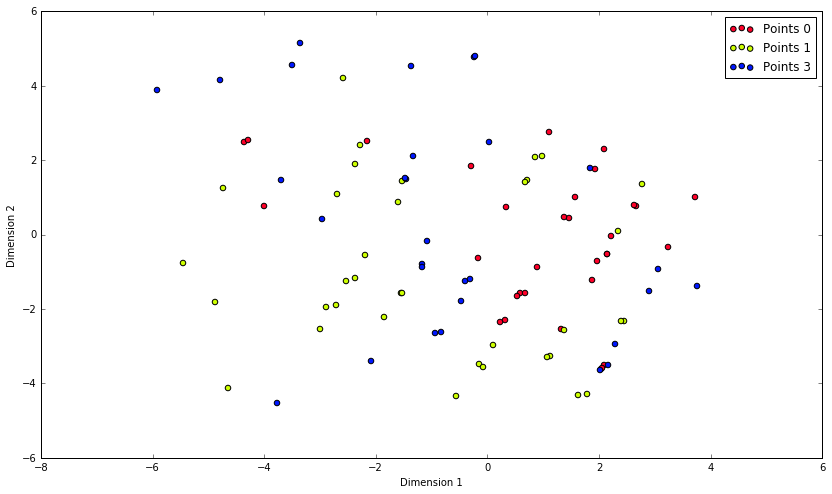

In [69]:
test_plot = reordered_matches[['Dimension 1', 'Dimension 2', 'pca_points']]
#display(test_plot)
# Scatterplotting the transformed data if it's 2 Dimensions
fig, ax = plt.subplots(figsize = (14,8))
cmap = cm.get_cmap('gist_rainbow')
    
for i, cluster in test_plot.groupby('pca_points'):   
    cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', 
                color = cmap((i)*1.0/(4)), label = 'Points %i'%(i), s=30);

In [29]:
""" Let's split the DF into the correct matches and the incorrect matches"""
incorrect_predictions = analyzing_data.loc[analyzing_data["diff1"] == 0]
incorrect_predictions.to_csv('incorrect_predictions.csv')

correct_predictions = analyzing_data.loc[analyzing_data["diff1"] == 1]
correct_predictions.to_csv('correct_predictions.csv')



In [ ]:
actual_data = pd.read_csv('predictions_on_ranked_data_NEW.csv')
actual_data = actual_data.drop(actual_data.columns[[0]], axis=1)
actual_data = actual_data.drop(['KNN', 'RandomForest', 'GNB', 'GMM', 'log', 'random'], axis=1)
display(actual_data)
actual_data.to_csv('actual_data_analysis.csv')

actual_data['diff1'] = actual_data.apply(lambda r: model_libs.predictions_diff(r['actual'], r['SVC']), axis=1)
accuracy = np.divide(actual_data['diff1'].sum(), float(len(actual_data['diff1'])))
print(accuracy)